# Learning

This notebook serves as supporting material for topics covered in **Chapter 18 - Learning from Examples** , **Chapter 19 - Knowledge in Learning**, **Chapter 20 - Learning Probabilistic Models** from the book *Artificial Intelligence: A Modern Approach*. This notebook uses implementations from [learning.py](https://github.com/aimacode/aima-python/blob/master/learning.py). Let's start by importing everything from the module:

In [1]:
from learning import *

## Contents

* Datasets
* Machine Learning Overview
* Plurality Learner Classifier
    * Overview
    * Implementation
    * Example
* k-Nearest Neighbours Classifier
    * Overview
    * Implementation
    * Example
* Perceptron Classifier
    * Overview
    * Implementation
    * Example
* MNIST Handwritten Digits Classification
    * Loading and Visualising
    * Testing
        * kNN Classifier

## Datasets

For the following tutorials we will use a range of datasets, to better showcase the strengths and weaknesses of the algorithms. The datasests are the following:

* [Fisher's Iris](https://github.com/aimacode/aima-data/blob/a21fc108f52ad551344e947b0eb97df82f8d2b2b/iris.csv). Each item represents a flower, with four measurements: the length and the width of the sepals and petals. Each item/flower is categorized into one of three species: Setosa, Versicolor and Virginica.

* [Zoo](https://github.com/aimacode/aima-data/blob/a21fc108f52ad551344e947b0eb97df82f8d2b2b/zoo.csv). The dataset holds different animals and their classification as "mammal", "fish", etc. The new animal we want to classify has the following measurements: 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 1, 0, 1 (don't concern yourself with what the measurements mean).

## Machine Learning Overview

In this notebook, we learn about agents that can improve their behavior through diligent study of their own experiences.

An agent is **learning** if it improves its performance on future tasks after making observations about the world.

There are three types of feedback that determine the three main types of learning:

* **Supervised Learning**:

In Supervised Learning the agent observes some example input-output pairs and learns a function that maps from input to output.

**Example**: Let's think of an agent to classify images containing cats or dogs. If we provide an image containing a cat or a dog, this agent should output a string "cat" or "dog" for that particular image. To teach this agent, we will give a lot of input-output pairs like {cat image-"cat"}, {dog image-"dog"} to the agent. The agent then learns a function that maps from an input image to one of those strings.

* **Unsupervised Learning**:

In Unsupervised Learning the agent learns patterns in the input even though no explicit feedback is supplied. The most common type is **clustering**: detecting potential useful clusters of input examples.

**Example**: A taxi agent would develop a concept of *good traffic days* and *bad traffic days* without ever being given labeled examples.

* **Reinforcement Learning**:

In Reinforcement Learning the agent learns from a series of reinforcements—rewards or punishments.

**Example**: Let's talk about an agent to play the popular Atari game—[Pong](http://www.ponggame.org). We will reward a point for every correct move and deduct a point for every wrong move from the agent. Eventually, the agent will figure out its actions prior to reinforcement were most responsible for it.

## Plurality Learner Classifier

### Overview

The Plurality Learner is a simple algorithm, used mainly as a baseline comparison for other algorithms. It finds the most popular class in the dataset and classifies any subsequent item to that class. Essentially, it classifies every new item to the same class. For that reason, it is not used very often, instead opting for more complicated algorithms when we want accurate classification.

![pL plot](images/pluralityLearner_plot.png)

Let's see how the classifier works with the plot above. There are three classes named **Class A** (orange-colored dots) and **Class B** (blue-colored dots) and **Class C** (green-colored dots). Every point in this plot has two **features** (i.e. X<sub>1</sub>, X<sub>2</sub>). Now, let's say we have a new point, a red star and we want to know which class this red star belongs to. Solving this problem by predicting the class of this new red star is our current classification problem.

The Plurality Learner will find the class most represented in the plot. ***Class A*** has four items, ***Class B*** has three and ***Class C*** has seven. The most popular class is ***Class C***. Therefore, the item will get classified in ***Class C***, despite the fact that it is closer to the other two classes.

### Implementation

Below follows the implementation of the PluralityLearner algorithm:

In [2]:
def PluralityLearner(dataset):
    """A very dumb algorithm: always pick the result that was most popular
    in the training data.  Makes a baseline for comparison."""
    most_popular = mode([e[dataset.target] for e in dataset.examples])

    def predict(example):
        "Always return same result: the most popular from the training set."
        return most_popular
    return predict

It takes as input a dataset and returns a function. We can later call this function with the item we want to classify as the argument and it returns the class it should be classified in.

The function first finds the most popular class in the dataset and then each time we call its "predict" function, it returns it. Note that the input ("example") does not matter. The function always returns the same class.

### Example

For this example, we will not use the Iris dataset, since each class is represented the same. This will throw an error. Instead we will use the zoo dataset.

In [3]:
zoo = DataSet(name="zoo")

pL = PluralityLearner(zoo)
print(pL([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 4, 1, 0, 1]))

mammal


The output for the above code is "mammal", since that is the most popular and common class in the dataset.

## k-Nearest Neighbours (kNN) Classifier

### Overview
The k-Nearest Neighbors algorithm is a non-parametric method used for classification and regression. We are going to use this to classify Iris flowers. More about kNN on [Scholarpedia](http://www.scholarpedia.org/article/K-nearest_neighbor).

![kNN plot](images/knn_plot.png)

Let's see how kNN works with a simple plot shown in the above picture.

We have co-ordinates (we call them **features** in Machine Learning) of this red star and we need to predict its class using the kNN algorithm. In this algorithm, the value of **k** is arbitrary. **k** is one of the **hyper parameters** for kNN algorithm. We choose this number based on our dataset and choosing a particular number is known as **hyper parameter tuning/optimising**. We learn more about this in coming topics.

Let's put **k = 3**. It means you need to find 3-Nearest Neighbors of this red star and classify this new point into the majority class. Observe that smaller circle which contains three points other than **test point** (red star). As there are two violet points, which form the majority, we predict the class of red star as **violet- Class B**.

Similarly if we put **k = 5**, you can observe that there are four yellow points, which form the majority. So, we classify our test point as **yellow- Class A**.

In practical tasks, we iterate through a bunch of values for k (like [1, 3, 5, 10, 20, 50, 100]), see how it performs and select the best one. 

### Implementation

Below follows the implementation of the kNN algorithm:

In [4]:
def NearestNeighborLearner(dataset, k=1):
    """k-NearestNeighbor: the k nearest neighbors vote."""
    def predict(example):
        """Find the k closest items, and have them vote for the best."""
        best = heapq.nsmallest(k, ((dataset.distance(e, example), e)
                                   for e in dataset.examples))
        return mode(e[dataset.target] for (d, e) in best)
    return predict

It takes as input a dataset and k (default value is 1) and it returns a function, which we can later use to classify a new item.

To accomplish that, the function uses a heap-queue, where the items of the dataset are sorted according to their distance from *example* (the item to classify). We then take the k smallest elements from the heap-queue and we find the majority class. We classify the item to this class.

### Example

We measured a new flower with the following values: 5.1, 3.0, 1.1, 0.1. We want to classify that item/flower in a class. To do that, we write the following:

In [5]:
iris = DataSet(name="iris")

kNN = NearestNeighborLearner(iris,k=3)
print(kNN([5.1,3.0,1.1,0.1]))

setosa


The output of the above code is "setosa", which means the flower with the above measurements is of the "setosa" species.

## Perceptron Classifier

### Overview

The Perceptron is a linear classifier. It works the same way as a neural network with no hidden layers (just input and output). First it trains its weights given a dataset and then it can classify a new item by running it through the network.

You can think of it as a single neuron. It has *n* synapses, each with its own weight. Each synapse corresponds to one item feature. Perceptron multiplies each item feature with the corresponding synapse weight and then adds them together (aka, the dot product) and checks whether this value is greater than the threshold. If yes, it returns 1. It returns 0 otherwise.

![perceptron](images/perceptron.png)

### Implementation

First, we train (calculate) the weights given a dataset, using the `BackPropagationLearner` function of `learning.py`. We then return a function, `predict`, which we will use in the future to classify a new item. The function computes the (algebraic) dot product of the item with the calculated weights. If the result is greater than a predefined threshold (usually 0.5, 0 or 1), it returns 1. If it is less than the threshold, it returns 0.

NOTE: The current implementation of the algorithm classifies an item into one of two classes. It is a binary classifier and will not work well for multi-class datasets.

In [6]:
def PerceptronLearner(dataset, learning_rate=0.01, epochs=100):
    """Logistic Regression, NO hidden layer"""
    i_units = len(dataset.inputs)
    o_units = 1  # As of now, dataset.target gives only one index.
    hidden_layer_sizes = []
    raw_net = network(i_units, hidden_layer_sizes, o_units)
    learned_net = BackPropagationLearner(dataset, raw_net, learning_rate, epochs)

    def predict(example):
        # Input nodes
        i_nodes = learned_net[0]

        # Activate input layer
        for v, n in zip(example, i_nodes):
            n.value = v

        # Forward pass
        for layer in learned_net[1:]:
            for node in layer:
                inc = [n.value for n in node.inputs]
                in_val = dotproduct(inc, node.weights)
                node.value = node.activation(in_val)

        # Hypothesis
        o_nodes = learned_net[-1]
        pred = [o_nodes[i].value for i in range(o_units)]
        return 1 if pred[0] >= 0.5 else 0

    return predict

The weights are trained from the `BackPropagationLearner`. Note that the perceptron is a one-layer neural network, without any hidden layers. So, in `BackPropagationLearner`, we will pass no hidden layers. From that function we get our network, which is just one node, with the weights calculated.

`PerceptronLearner` returns `predict`, a function that can be used to classify a new item.

That function passes the input/example through the network, calculating the dot product of the input and the weights. If that value is greater than or equal to 0.5, it returns 1. Otherwise it returns 0.

### Example

We will train the Perceptron on the iris dataset. Because, though, the algorithm is a binary classifier (which means it classifies an item in one of two classes) and the iris dataset has three classes, we need to transform the dataset into a proper form, with only two classes. Therefore, we will remove the third and final class of the dataset, *Virginica*.

Then, we will try and classify the item/flower with measurements of 5,3,1,0.1.

In [7]:
iris = DataSet(name="iris")
iris.remove_examples("virginica")
iris.classes_to_numbers()

perceptron = PerceptronLearner(iris)
print(perceptron([5,3,1,0.1]))

0


The output is 0, which means the item is classified in the first class, *setosa*. This is indeed correct. Note that the Perceptron algorithm is not perfect and may produce false classifications.

## MNIST Handwritten Digits Classification

The MNIST database, available from [this page](http://yann.lecun.com/exdb/mnist/), is a large database of handwritten digits that is commonly used for training and testing/validating in Machine learning.

The dataset has **60,000 training images** each of size 28x28 pixels with labels and **10,000 testing images** of size 28x28 pixels with labels.

In this section, we will use this database to compare performances of different learning algorithms.

It is estimated that humans have an error rate of about **0.2%** on this problem. Let's see how our algorithms perform!

NOTE: We will be using external libraries to load and visualize the dataset smoothly ([numpy](http://www.numpy.org/) for loading and [matplotlib](http://matplotlib.org/) for visualization). You do not need previous experience of the libraries to follow along.

### Loading MNIST digits data

Let's start by loading MNIST data into numpy arrays.

In [8]:
import os, struct
import array
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [9]:
def load_MNIST(path="aima-data/MNIST"):
    "helper function to load MNIST data"
    train_img_file = open(os.path.join(path, "train-images-idx3-ubyte"), "rb")
    train_lbl_file = open(os.path.join(path, "train-labels-idx1-ubyte"), "rb")
    test_img_file = open(os.path.join(path, "t10k-images-idx3-ubyte"), "rb")
    test_lbl_file = open(os.path.join(path, 't10k-labels-idx1-ubyte'), "rb")
    
    magic_nr, tr_size, tr_rows, tr_cols = struct.unpack(">IIII", train_img_file.read(16))
    tr_img = array.array("B", train_img_file.read())
    train_img_file.close()    
    magic_nr, tr_size = struct.unpack(">II", train_lbl_file.read(8))
    tr_lbl = array.array("b", train_lbl_file.read())
    train_lbl_file.close()
    
    magic_nr, te_size, te_rows, te_cols = struct.unpack(">IIII", test_img_file.read(16))
    te_img = array.array("B", test_img_file.read())
    test_img_file.close()
    magic_nr, te_size = struct.unpack(">II", test_lbl_file.read(8))
    te_lbl = array.array("b", test_lbl_file.read())
    test_lbl_file.close()

#     print(len(tr_img), len(tr_lbl), tr_size)
#     print(len(te_img), len(te_lbl), te_size)
    
    train_img = np.zeros((tr_size, tr_rows*tr_cols), dtype=np.int16)
    train_lbl = np.zeros((tr_size,), dtype=np.int8)
    for i in range(tr_size):
        train_img[i] = np.array(tr_img[i*tr_rows*tr_cols : (i+1)*tr_rows*tr_cols]).reshape((tr_rows*te_cols))
        train_lbl[i] = tr_lbl[i]
        
    test_img = np.zeros((te_size, te_rows*te_cols), dtype=np.int16)
    test_lbl = np.zeros((te_size,), dtype=np.int8)
    for i in range(te_size):
        test_img[i] = np.array(te_img[i*te_rows*te_cols : (i+1)*te_rows*te_cols]).reshape((te_rows*te_cols))
        test_lbl[i] = te_lbl[i]
        
    return(train_img, train_lbl, test_img, test_lbl)

The function `load_MNIST()` loads MNIST data from files saved in `aima-data/MNIST`. It returns four numpy arrays that we are going to use to train and classify hand-written digits in various learning approaches.

In [10]:
train_img, train_lbl, test_img, test_lbl = load_MNIST()

Check the shape of these NumPy arrays to make sure we have loaded the database correctly.

Each 28x28 pixel image is flattened to a 784x1 array and we should have 60,000 of them in training data. Similarly, we should have 10,000 of those 784x1 arrays in testing data.

In [11]:
print("Training images size:", train_img.shape)
print("Training labels size:", train_lbl.shape)
print("Testing images size:", test_img.shape)
print("Training labels size:", test_lbl.shape)

Training images size: (60000, 784)
Training labels size: (60000,)
Testing images size: (10000, 784)
Training labels size: (10000,)


### Visualizing MNIST digits data

To get a better understanding of the dataset, let's visualize some random images for each class from training and testing datasets.

In [12]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)

def show_MNIST(dataset, samples=8):
    if dataset == "training":
        labels = train_lbl
        images = train_img
    elif dataset == "testing":
        labels = test_lbl
        images = test_img
    else:
        raise ValueError("dataset must be 'testing' or 'training'!")
        
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in labels])
        idxs = np.random.choice(idxs[0], samples, replace=False)
        for i , idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples, num_classes, plt_idx)
            plt.imshow(images[idx].reshape((28, 28)))
            plt.axis("off")
            if i == 0:
                plt.title(cls)


    plt.show()

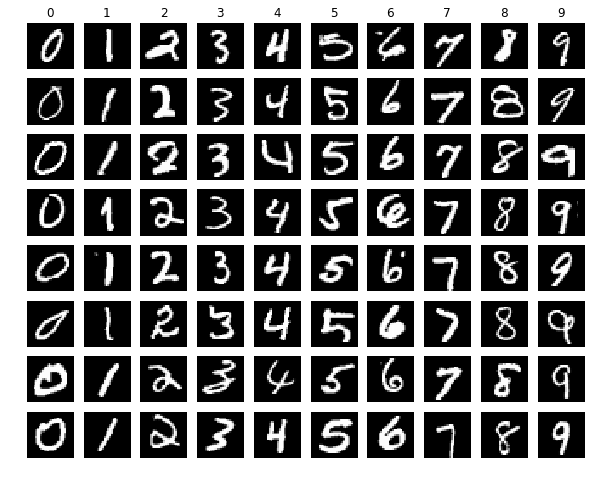

In [13]:
# takes 5-10 seconds to execute this
show_MNIST("training")

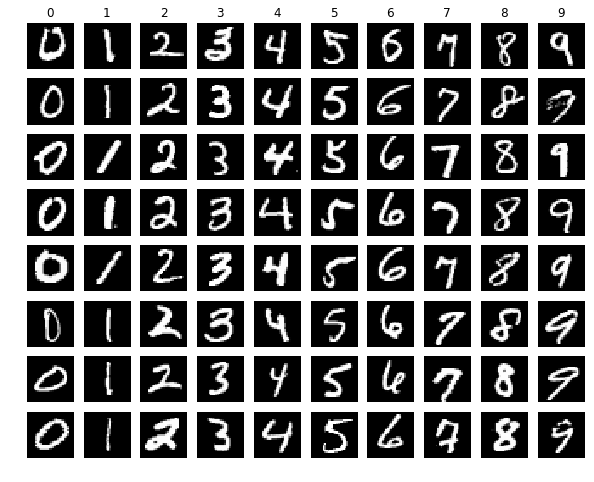

In [14]:
# takes 5-10 seconds to execute this
show_MNIST("testing")

Let's have a look at the average of all the images of training and testing data.

In [15]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)

def show_ave_MNIST(dataset):
    if dataset == "training":
        print("Average of all images in training dataset.")
        labels = train_lbl
        images = train_img
    elif dataset == "testing":
        print("Average of all images in testing dataset.")
        labels = test_lbl
        images = test_img
    else:
        raise ValueError("dataset must be 'testing' or 'training'!")
        
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in labels])
        print("Digit", y, ":", len(idxs[0]), "images.")
        
        ave_img = np.mean(np.vstack([images[i] for i in idxs[0]]), axis = 0)
#         print(ave_img.shape)
        
        plt.subplot(1, num_classes, y+1)
        plt.imshow(ave_img.reshape((28, 28)))
        plt.axis("off")
        plt.title(cls)


    plt.show()

Average of all images in training dataset.
Digit 0 : 5923 images.
Digit 1 : 6742 images.
Digit 2 : 5958 images.
Digit 3 : 6131 images.
Digit 4 : 5842 images.
Digit 5 : 5421 images.
Digit 6 : 5918 images.
Digit 7 : 6265 images.
Digit 8 : 5851 images.
Digit 9 : 5949 images.


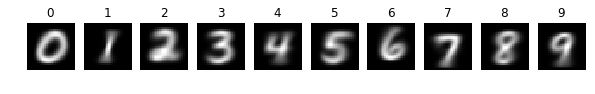

Average of all images in testing dataset.
Digit 0 : 980 images.
Digit 1 : 1135 images.
Digit 2 : 1032 images.
Digit 3 : 1010 images.
Digit 4 : 982 images.
Digit 5 : 892 images.
Digit 6 : 958 images.
Digit 7 : 1028 images.
Digit 8 : 974 images.
Digit 9 : 1009 images.


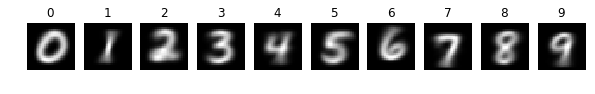

In [16]:
show_ave_MNIST("training")
show_ave_MNIST("testing")

## Testing

Now, let us convert this raw data into `DataSet.examples` to run our algorithms defined in `learning.py`. Every image is represented by 784 numbers (28x28 pixels) and we append them with its label or class to make them work with our implementations in learning module.

In [17]:
print(train_img.shape, train_lbl.shape)
temp_train_lbl = train_lbl.reshape((60000,1))
training_examples = np.hstack((train_img, temp_train_lbl))
print(training_examples.shape)

(60000, 784) (60000,)
(60000, 785)


Now, we will initialize a DataSet with our training examples, so we can use it in our algorithms.

In [18]:
# takes ~8 seconds to execute this
MNIST_DataSet = DataSet(examples=training_examples, distance=manhattan_distance)

Moving forward we can use `MNIST_DataSet` to test our algorithms.

### k-Nearest Neighbors

We will now try to classify a random image from the dataset using the kNN classifier.

First, we choose a number from 0 to 9999 for `test_img_choice` and we are going to predict the class of that test image.

In [19]:
from learning import NearestNeighborLearner

# takes ~20 Secs. to execute this
kNN = NearestNeighborLearner(MNIST_DataSet,k=3)
print(kNN(test_img[211]))

5


To make sure that the output we got is correct, let's plot that image along with its label.

Actual class of test image: 5


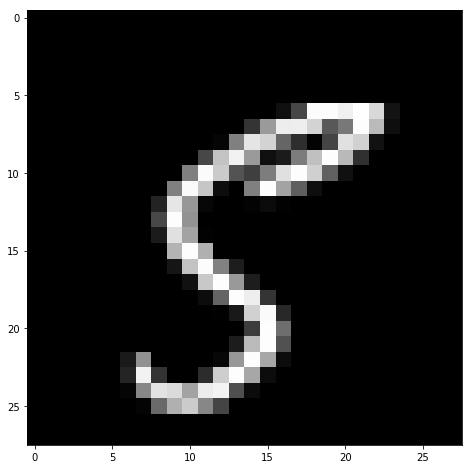

In [20]:
print("Actual class of test image:", test_lbl[211])
plt.imshow(test_img[211].reshape((28,28)))

Hurray! We've got it correct. Don't worry if our algorithm predicted a wrong class. With this techinique we have only ~97% accuracy on this dataset. Let's try with a different test image and hope we get it this time.

You might have recognized that our algorithm took ~20 seconds to predict a single image. How would we even predict all 10,000 test images? Yeah, the implementations we have in our learning module are not optimized to run on this particular dataset, as they are written with readability in mind, instead of efficiency.